## En este codigo esta explicado como se usaron las imagenes satelitales de Sentinel-2 usando los servidores de google earth para calcular el area en km2, de las zonas urbanas, rurales y de agua, para cada ciudad y en cada año que estamos analizando. Al final la base se exporta y se une en el script de *Bases final*

In [1]:
import ee
import geemap.core as geemap
from ee import batch
import calendar
import pandas as pd 
import geopandas as gpd
import re
import unicodedata
from shapely.geometry import Point
import time 
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from geopy.distance import geodesic
from pykrige.kriging_tools import write_asc_grid
from sklearn.preprocessing import MinMaxScaler

# Nos autenticamos en los servidores de google earth
ee.Authenticate()
ee.Initialize(project='ee-iaeconomiaturistas')
print(ee.String('Hello from the Earth Engine servers!').getInfo())


# Funciones a usar
def arreglar_texto(df , variable , nombre):
    if variable not in df.columns:
        print('La columna' , variable ,'no existe en el DataFrame')
        return df
        
    df[variable] = df[variable].str.lower()
    df[variable] = df[variable].str.replace(' ', '', regex=False)
    df[variable] = df[variable].str.replace(r'[^\w\s]', '', regex=True)   
    df[variable] = df[variable].str.replace('sanandresdetumaco', 'tumaco', regex=False)
    df[variable] = df[variable].str.replace('ct$', '', regex=True)
    df[variable] = df[variable].str.replace('bogotadc', 'bogota', regex=False)
    df[variable] = df[variable].apply(eliminar_tildes)
    df = df.rename(columns={variable: nombre})
    return df

def eliminar_tildes(str):
    return ''.join(
        i for i in unicodedata.normalize('NFKD', str)
        if unicodedata.category(i) != 'Mn')


Successfully saved authorization token.
Hello from the Earth Engine servers!


In [2]:
# Cargamos la base de las ciudades que estamos analizando para unirlas con sus geometrias, dado que esta variable solo tiene puntos
ciudades= pd.read_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\ciudades.csv')
ciudades['geometry'] = ciudades.apply(lambda i: Point(i['lng'], i['lat']), axis=1)
ciudades= arreglar_texto(ciudades, 'city', 'Ciudad')
ciudades_geometry21= gpd.GeoDataFrame(ciudades, geometry='geometry')
ciudades_geometry21 

,Ciudad,lat,lng,country,iso2,admin_name,capital,population,population_proper,geometry
0,bogota,4.7111,-74.0722,Colombia,CO,Bogotá,primary,7968095,7743955,POINT (-74.0722 4.7111)
1,medellin,6.2308,-75.5906,Colombia,CO,Antioquia,admin,2529403,2529403,POINT (-75.5906 6.2308)
2,cali,3.4206,-76.5222,Colombia,CO,Valle del Cauca,admin,2471474,2471474,POINT (-76.5222 3.4206)
3,barranquilla,10.9833,-74.8019,Colombia,CO,Atlántico,admin,1326588,1274250,POINT (-74.8019 10.9833)
4,cartagena,10.4000,-75.5000,Colombia,CO,Bolívar,admin,914552,914552,POINT (-75.5 10.4)
...,...,...,...,...,...,...,...,...,...,...
79,leticia,-4.2167,-69.9333,Colombia,CO,Amazonas,admin,33503,32450,POINT (-69.9333 -4.2167)
80,lavirginia,4.9167,-75.8333,Colombia,CO,Risaralda,minor,32330,32330,POINT (-75.8333 4.9167)
81,mitu,1.1983,-70.1733,Colombia,CO,Vaupés,admin,28382,28382,POINT (-70.1733 1.1983)
82,inirida,3.8653,-67.9239,Colombia,CO,Guainía,admin,20279,19816,POINT (-67.9239 3.8653)


In [3]:
# Cargamos los poligonos de las ciudades y las unimos
areas_ciudades = gpd.read_file('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Ciudades Colombia Geometry.geojson')
areas_ciudades = arreglar_texto(areas_ciudades , 'Ciudades' , 'Ciudad')
areas_ciudades['geometry_copy'] = areas_ciudades['geometry'].copy()
areas_ciudades = pd.merge(ciudades_geometry21 , areas_ciudades, on='Ciudad', how='left')

In [4]:
# Dejamos solo las variables que necesitamos para el analasis
columnas_deseadas = ['Ciudad' , 'geometry_copy']
areas_ciudades = areas_ciudades[columnas_deseadas].dropna()
areas_ciudades

,Ciudad,geometry_copy
0,bogota,"POLYGON ((-74.05613 4.7763, -74.05951 4.77519,..."
1,medellin,"POLYGON ((-75.54463 6.34868, -75.57203 6.34771..."
2,cali,"POLYGON ((-76.52195 3.36074, -76.50713 3.36522..."
3,barranquilla,"POLYGON ((-74.80539 11.03706, -74.82747 11.045..."
4,cartagena,"POLYGON ((-75.46004 10.43033, -75.46269 10.429..."
...,...,...
79,leticia,"POLYGON ((-69.94426 -4.22371, -69.94227 -4.223..."
80,lavirginia,"POLYGON ((-75.87017 4.89399, -75.87276 4.89569..."
81,mitu,"POLYGON ((-70.23955 1.24303, -70.23443 1.2437,..."
82,inirida,"POLYGON ((-67.90653 3.88167, -67.90396 3.88461..."


In [5]:
# Verificamos si hay goemetrias faltantes
areas_ciudades[areas_ciudades.isna().any(axis=1)]

,Ciudad,geometry_copy


In [6]:
# Funcion del metodo OTSU para encontrar el umbrar optimo para determinar las zonas urbanas 
def otsu(histogram):
    histogram = ee.Dictionary(histogram)
    counts = ee.Array(histogram.get('histogram'))
    bins = ee.Array(histogram.get('bucketMeans'))
    total = counts.reduce('sum', [0]).get([0])
    sum_total = counts.multiply(bins).reduce('sum', [0]).get([0])
    mean_total = sum_total.divide(total)
    size = counts.length().get([0])
    
    def computeBetweenVar(i):
        i = ee.Number(i).toInt()
        w_b = counts.slice(0, 0, i).reduce('sum', [0]).get([0])
        w_f = total.subtract(w_b)
        sum_b = counts.slice(0, 0, i).multiply(bins.slice(0, 0, i)).reduce('sum', [0]).get([0])
        sum_f = sum_total.subtract(sum_b)
        m_b = sum_b.divide(w_b)
        m_f = sum_f.divide(w_f)
        between_var = w_b.multiply(w_f).multiply(m_b.subtract(m_f).pow(2))
        return between_var
    
    indices = ee.List.sequence(1, size.subtract(1))
    between_vars = indices.map(computeBetweenVar)
    max_var = ee.Array(between_vars).reduce('max', [0]).get([0])
    threshold_index = between_vars.indexOf(max_var)
    threshold = bins.get([threshold_index])
    
    return threshold


# Funcion para calcular los umbrales optimos para las zonas verdes y agua 
# Vamos a usar percentiles para ajustarnos a cada una de las 81 ciuades y llegar a concluciones significativas
def calcular_percentil(imagen, banda, percentil , estudio):
    reducer = ee.Reducer.percentile([percentil])
    percentil_value = imagen.select(banda).reduceRegion(
        reducer=reducer,
        geometry=estudio,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    ).get(banda)
    return ee.Number(percentil_value)


# Dado que nuestra variable es local y es geometry, necesitamos convertir estas geometrias de las ciudades a objetos que puedan manejar los servidores de google earth,
# con esta funcion verificamos el tipo de geometria y la convertimos
def geojson_to_ee_geometry(geometry):
    geometry_type = geometry['type']

    if geometry_type == 'Polygon':
        coords = geometry['coordinates']
        return ee.Geometry.Polygon(coords)
    
    elif geometry_type == 'MultiPolygon':
        coords = geometry['coordinates']
        return ee.Geometry.MultiPolygon(coords)
    
    elif geometry_type == 'LineString':
        coords = geometry['coordinates']
        return ee.Geometry.LineString(coords)
    
    elif geometry_type == 'GeometryCollection':
        geometries = geometry['geometries']
        ee_geometries = [geojson_to_ee_geometry(geom) for geom in geometries]
        return ee.FeatureCollection(geometries)
    
    else:
        raise ValueError(f"Tipo de geometría no soportado: {geometry_type}")

s2_clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

# Una mascara que le aplicaremos a las fotos para eliminar las nubes 
def maskS2clouds(image):
    img_id = image.get('system:index')
    cloud_prob = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY') \
        .filter(ee.Filter.eq('system:index', img_id)) \
        .first()
    
    def apply_cloud_mask(cloud_prob_image):
        cloud_prob_threshold = 40 
        has_probability = cloud_prob_image.bandNames().contains('probability')
        is_not_cloud = ee.Algorithms.If(
            has_probability,
            cloud_prob_image.select('probability').lt(cloud_prob_threshold),
            ee.Image.constant(1))
        return image.updateMask(is_not_cloud).copyProperties(image, ["system:time_start"])
        
    return ee.Algorithms.If(cloud_prob, apply_cloud_mask(cloud_prob), image)


# Iniciamios diccionarios para guardar los resultados    
resultados = {}
imagenes_resultados = {}
c=0

### Profe este codigo demora un monton en correr (aprox 2.5 horas) asi que si lo planeas en correr pues dale tiempito jaja

In [14]:
for i in range(len(areas_ciudades)):
    c=c+1
    row = areas_ciudades.iloc[i] 
    geojson_geometry = row['geometry_copy'].__geo_interface__
    area_estudio = geojson_to_ee_geometry(geojson_geometry)
    ciudad = row['Ciudad'] 

    for año in range(2018, 2024):
        if año == 2020: # Eliminamos 2020 por que no lo estamos analizando 
            continue
    
        fecha_inicio = f'{año}-01-01'
        fecha_fin = f'{año}-12-31'

        # Creamos una coleccion en el area de estudio 
        coleccion = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(area_estudio) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)) # Dado que estamos usando la mascara maskS2clouds podemos permitirnos tener un porcentaje de nuebes alto 

        # Filtrar la colección por fecha y aplicar enmascaramiento, dejamos maximo 55 imagenes para que el codigo corra mas rapido 
        coleccion_año = coleccion.filterDate(fecha_inicio, fecha_fin).map(maskS2clouds).limit(55)

        # Verificar el número de imágenes disponibles
        num_images = coleccion_año.size().getInfo()
        print(f"Año: {año}, Número de imágenes después del enmascaramiento: {num_images}")

        # Si no hay imagenes completamos el diccionario con None para despues usar KNN 
        if num_images == 0:
            print(f"No hay imágenes disponibles para el año {año} después del enmascaramiento.")
            if ciudad not in resultados:
                resultados[ciudad] = []
            resultados[ciudad].append([año, None , None , None])
            continue

        # Selecionamos las bandas que necesitamos para los diferentes indices 
        bandas_medianas = coleccion_año.select(['B3', 'B4', 'B8', 'B11' , 'B2' , 'B12']).median().clip(area_estudio)
        bandas_medianas = bandas_medianas.multiply(0.0001)
    
        # Calcular el NDWI , NDBI , NDVI , GNDVI , MNDWI , EVI y AWEIsh
        
        '''
        NDVI (Normalized Difference Vegetation Index): Cuanto mayor es el valor de NDVI (cercano a 1), más densa y saludable es la vegetación.
        GNDVI (Green Normalized Difference Vegetation Index): Variante del NDVI, usa la banda verde en lugar de la roja para detectar actividad fotosintética.
        EVI (Enhanced Vegetation Index): Similar al NDVI pero con mayor sensibilidad en áreas de vegetación densa y corrige la interferencia de aerosoles.
        NDWI (Normalized Difference Water Index): Detecta la presencia de agua.
        MNDWI (Modified Normalized Difference Water Index): Variante del NDWI que usa la banda SWIR para mejorar la detección de agua en áreas urbanas.
        NDBI (Normalized Difference Built-up Index): Detecta áreas urbanas y desarrollo humano.
        AWEIsh (Automated Water Extraction Index - Shadow Removal): Detecta agua automáticamente y corrige sombras en terrenos montañosos.

        '''
        ndwi = bandas_medianas.normalizedDifference(['B3', 'B8']).rename('NDWI')
        ndbi = bandas_medianas.normalizedDifference(['B11', 'B8']).rename('NDBI')
        ndvi = bandas_medianas.normalizedDifference(['B8', 'B4']).rename('NDVI')
        gndvi = bandas_medianas.normalizedDifference(['B8', 'B3']).rename('GNDVI')
        mndwi = bandas_medianas.normalizedDifference(['B3', 'B11']).rename('MNDWI')
        evi = bandas_medianas.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
            'NIR': bandas_medianas.select('B8'),
            'RED': bandas_medianas.select('B4'),
            'BLUE': bandas_medianas.select('B2')
            }
            ).rename('EVI')
        aweish = bandas_medianas.expression(
            'B3 + 2.5 * B8 - 1.5 * (B11 + B12) - 0.25 * B2',
            {
            'B2': bandas_medianas.select('B2'),
            'B3': bandas_medianas.select('B3'),
            'B8': bandas_medianas.select('B8'),
            'B11': bandas_medianas.select('B11'),
            'B12': bandas_medianas.select('B12')
            }
            ).rename('AWEIsh')
        
        # Creamos una imagen para cada ciudad con los diferentes indices calculados. 
        imagen_compuesta = bandas_medianas.addBands([ndwi, ndbi, ndvi , evi , gndvi , mndwi , aweish])

        # Calcular histograma del NDBI para determinar el umbral óptimo
        ndbi_histogram = imagen_compuesta.select('NDBI').reduceRegion(
            reducer=ee.Reducer.histogram(255, 2),  
            geometry=area_estudio,
            scale=10,
            maxPixels=1e9,
            bestEffort=True)
        ndbi_hist = ndbi_histogram.get('NDBI')

    
        # Calcular umbrales usando Otsu para NDBI
        if ndbi_histogram:
                ndbi_threshold = otsu(ndbi_hist)
                ndbi_threshold_num = ee.Number(ndbi_threshold)
        else:
            ndbi_threshold = 0.2  # Valor predeterminado en caso de que no se pueda usar otsu 
            ndbi_threshold_num = ee.Number(ndbi_threshold)  

        ndvi_threshold_num = calcular_percentil(imagen_compuesta, 'NDVI', 55, area_estudio) # El numero representa el percentil que queremos calcular 
        evi_threshold_num = calcular_percentil(imagen_compuesta, 'EVI', 45, area_estudio) # Dado que queremos quitar las zonas verdes calculamos un ndvi y evi algo alto 

        print(f"Umbrales calculados - NDVI: {ndvi_threshold_num.getInfo()}, EVI: {evi_threshold_num.getInfo()}") # Para mostrar los indices calculados


        # Clasificamos las zonas urbanas con el NDBI y el umbral optimo del otsu quitando las zonas verdes calculadas por el EVI y NDVI y las zonas de agua del NDWI
        areas_urbanas = imagen_compuesta.select('NDBI').gt(ndbi_threshold_num) \
        .And(imagen_compuesta.select('EVI').lt(evi_threshold_num)) \
        .And(imagen_compuesta.select('NDVI').lt(ndvi_threshold_num)) \
        .And(imagen_compuesta.select('NDWI').lt(ee.Number(0.0))) \
        .rename('urban')

        # Volvemos a calcular los umbrales para las zonas urbanas 
        ndvi_threshold_num_R = calcular_percentil(imagen_compuesta, 'NDVI', 86, area_estudio)
        evi_threshold_num_R = calcular_percentil(imagen_compuesta, 'EVI', 81, area_estudio)
        gndvi_threshold_num = calcular_percentil(imagen_compuesta, 'GNDVI', 86, area_estudio)

        #print(f"Umbrales calculados - NDVI: {ndvi_threshold_num_R.getInfo()}, EVI: {evi_threshold_num_R.getInfo()}")

        # Encontramos las zonmas urbanas en donde todos los indicadores sean altos
        zonas_verdes = imagen_compuesta.select('NDVI').gt(ndvi_threshold_num_R) \
            .And(imagen_compuesta.select('EVI').gt(evi_threshold_num_R)) \
            .And(imagen_compuesta.select('GNDVI').gt(gndvi_threshold_num)) \
            .rename('zonas_verdes')

        ## Calculamos las zonas de agua 
        mndwi_threshold_num = calcular_percentil(imagen_compuesta, 'MNDWI', 91, area_estudio)
        aweish_threshold_num = calcular_percentil(imagen_compuesta, 'AWEIsh', 92, area_estudio)
        ndwi_threshold_num = calcular_percentil(imagen_compuesta, 'NDWI', 91, area_estudio)

        # Hacemos lo mismo
        areas_agua = imagen_compuesta.select('NDWI').gt(ndwi_threshold_num ) \
            .And(imagen_compuesta.select('MNDWI').gt(mndwi_threshold_num)) \
            .And(imagen_compuesta.select('AWEIsh').gt(aweish_threshold_num)) \
            .rename('agua') 
    
        # Ahora con las imagenes creadas vamos a calcular las diferentes areas verdes urbanas y de agua 
        area_pixeles_verdes = zonas_verdes.reduceRegion(
            reducer=ee.Reducer.sum(),geometry=area_estudio,
            scale=10,maxPixels=1e9,bestEffort=True).get('zonas_verdes')

        # Calcular el área de las zonas urbanas
        area_pixeles_urbanas = areas_urbanas.reduceRegion(
            reducer=ee.Reducer.sum(),geometry=area_estudio,
            scale=10,maxPixels=1e9,bestEffort=True).get('urban')

        # Calcular el área de las zonas urbanas
        area_pixeles_agua = areas_agua.reduceRegion(
            reducer=ee.Reducer.sum(),geometry=area_estudio,
            scale=10,maxPixels=1e9,bestEffort=True).get('agua')


        # Convertir a números y calcular áreas en Kilometros cuadrados sabiendo que cada pixel es 100 m²
        area_pixeles_verdes = ee.Number(area_pixeles_verdes)
        area_km2_verdes = area_pixeles_verdes.multiply(100).divide(1e6)  # 100 m² por píxel

        area_pixeles_urbanas = ee.Number(area_pixeles_urbanas)
        area_km2_urbanas = area_pixeles_urbanas.multiply(100).divide(1e6)

        area_pixeles_agua = ee.Number(area_pixeles_agua)
        area_km2_agua = area_pixeles_agua.multiply(100).divide(1e6)

        # Obtener los valores y en caso de arrojar error poner None 
        try:
            area_km2_valor_verdes = area_km2_verdes.getInfo()
        except:
            print('Error al tratar de obtener area rural para' , ciudad , 'en el ano' ,año)
            area_km2_valor_verdes = None

        try:
            area_km2_valor_urbanas = area_km2_urbanas.getInfo()
        except:
            print('Error al tratar de obtener area urbana para' , ciudad , 'en el ano' ,año)
            area_km2_valor_urbanas = None
        try:
            area_km2_valor_agua = area_km2_agua.getInfo()
        except:
            print('Error al tratar de obtener area agua para' , ciudad , 'en el ano' ,año)
            area_km2_valor_agua = None


        # Agregamos las imagenes y areas a los diccionarios para volverlos un df despues
        if ciudad not in resultados:
            resultados[ciudad] = []

        if ciudad not in imagenes_resultados:
            imagenes_resultados[ciudad] = []

        imagenes_resultados[ciudad].append([año, areas_urbanas , zonas_verdes , areas_agua])
        
        resultados[ciudad].append([año, area_km2_valor_urbanas , area_km2_valor_verdes ,area_km2_valor_agua])

        print(resultados)
        print(c)

# Si el codigo corre completo, se vera algo como lo que se imprimio abajo, pero con todas las ciuades y para todos los a;os

#Año: 2018, Número de imágenes después del enmascaramiento: 15
#Umbrales calculados - NDVI: 0.1835615742969714, EVI: 0.08532861337284849
#{'bogota': [[2018, 189.97533254901958, 37.85034470588236, 0.8084011764705882]]}
#2
#Año: 2019, Número de imágenes después del enmascaramiento: 50 ...

Año: 2018, Número de imágenes después del enmascaramiento: 15
Umbrales calculados - NDVI: 0.1835615742969714, EVI: 0.08532861337284849
{'bogota': [[2018, 189.97533254901958, 37.85034470588236, 0.8084011764705882]]}
2
Año: 2019, Número de imágenes después del enmascaramiento: 50


KeyboardInterrupt: 

In [9]:
# Este es el dicionario donde se almacenan las imagenes
imagenes_resultados

{'bogota': [[2018,
   <ee.image.Image at 0x21e233ebb50>]]}

In [16]:
# Verificar que lo que se guardo en el diccionario son imagenes
imagenes_resultados['bogota'][0][1] # Podemos ver que lo que se genera es un objeto tipo imagen 

In [17]:
# Con esta funcion se puede graficar las diferentes areas dado que es muy probable que no se corra el codigo, puse las imagenes que arrojaria
Map = geemap.Map()

visualizacion_areas_urbanas = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']  
}
Map.addLayer(imagenes_resultados['bogota'][0][1], visualizacion_areas_urbanas, 'Áreas Urbanas')

Map.centerObject(area_estudio, 10)
Map

Map(center=[4.640048062301101, -74.11574059370322], controls=(ZoomControl(options=['position', 'zoom_in_text',…

![Bogota zonas urbanas.jpg](<attachment:Bogota zonas urbanas.jpg>)
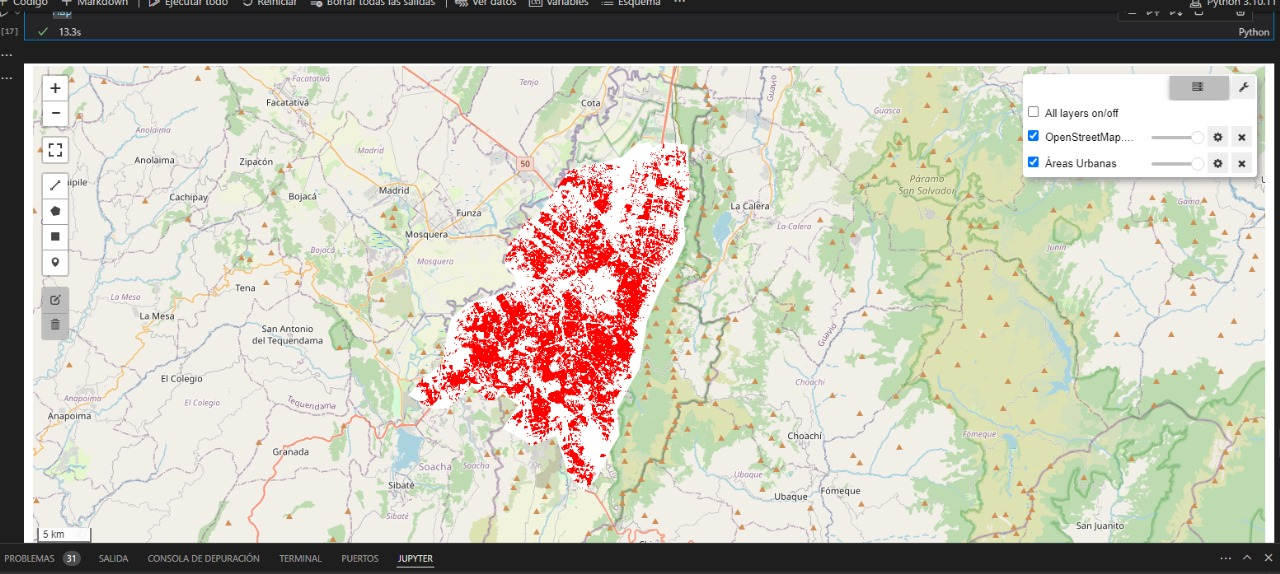

In [18]:
# Con esta funcion se puede graficar las diferentes areas. Aca estamos graficando las areas rurales 
Map = geemap.Map()

visualizacion_areas_urbanas = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']  
}
Map.addLayer(imagenes_resultados['bogota'][0][2], visualizacion_areas_urbanas, 'Áreas Urbanas')

Map.centerObject(area_estudio, 10)
Map

Map(center=[4.640048062301101, -74.11574059370322], controls=(ZoomControl(options=['position', 'zoom_in_text',…

![Bogota zonas verdes.jpg](<attachment:Bogota zonas verdes.jpg>)
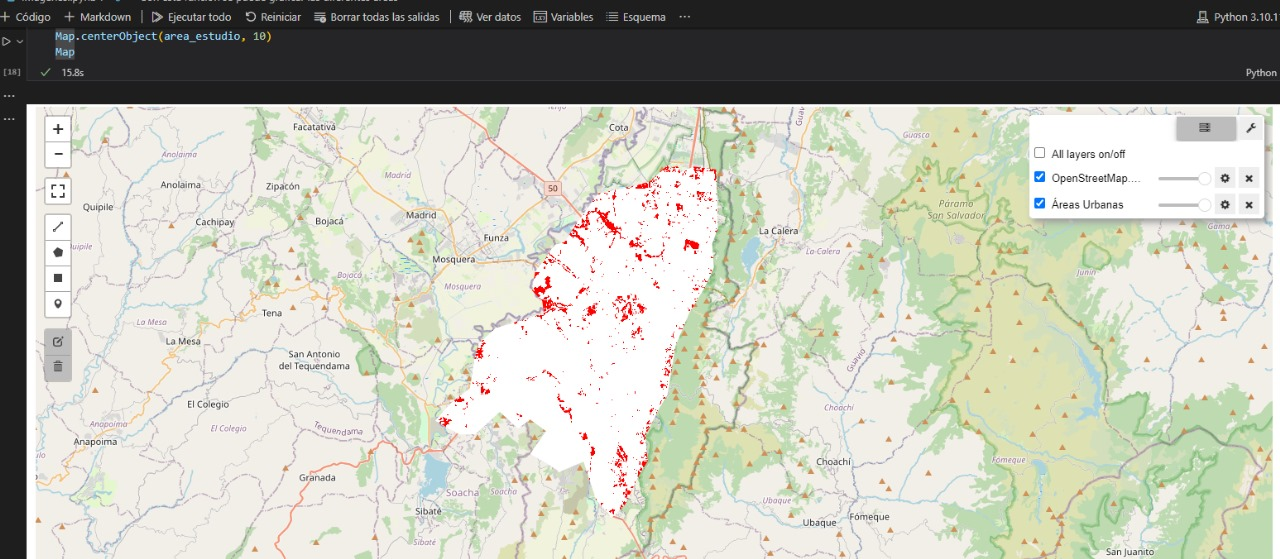

## Nota: En caso de que las imagenes no carguen, estan en la carpeta de imagenes que se subio 

In [ ]:
# Volvemos los datos un df 
data_list = []
for ciudad, registros in resultados.items():
    for registro in registros:
        if len(registro) == 4:
            año, area1, area2, area3 = registro
        elif len(registro) == 2:
            año, area1 = registro
            area2, area3 = None, None  
            print(f"Registro inesperado para la ciudad {ciudad}: {registro}")
            año, area1, area2, area3 = None, None, None, None
        data_list.append([ciudad, año, area1, area2, area3])

df = pd.DataFrame(data_list, columns=['ciudad', 'año', 'area1', 'area2', 'area3'])

In [ ]:
# Importamos la base que se exporto cuando se corrio el codigo para que se pueda ver
areas = pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Areas_Finales.xlsx')

### Observemos como se genero la base que acabamos de crear: 

In [3]:
areas.head(10)

,ciudad,año,Area Urbana,Area Rural,Area Agua
0,bogota,2018,189.975333,37.850345,0.808401
1,bogota,2019,213.094335,53.191889,1.238585
2,bogota,2021,218.924291,54.775529,0.566466
3,bogota,2022,217.850592,52.881088,0.706866
4,bogota,2023,217.187436,54.555076,1.116556
5,medellin,2018,78.806596,19.281878,0.336355
6,medellin,2019,81.961358,20.062621,0.286349
7,medellin,2021,80.073025,18.700133,0.350471
8,medellin,2022,81.386937,19.725720,0.434761
9,medellin,2023,80.515962,19.893864,0.537594


# Autores: Pablo Reyes y Victoria Vargas 
# Universidad Externado de Colombia 
# Revisado: Daniel Godoy 